# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



**Source**: This dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



## A. Business Understanding

##### _Problem 1: Understanding the Data_

The dataset is collected from a Portuguese bank that used its own contact-center to do directed marketing campaigns - mostly by telephone. The dataset collected is related to **17 campaigns** that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. 

During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a number of attributes was stored and if there was a success (the target variable). For the whole database considered, there were 6499
successes (8% success rate).

##### _Problem 1a: Import Relevant Libraries_

In [44]:
## Basic libs
import pandas as pd
import numpy as np

## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Bulid the data Model
from sklearn.cluster import KMeans
from sklearn import datasets
from io import StringIO
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score,accuracy_score,recall_score,f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

sns.set_style('darkgrid')

import time


##### _Problem 2: Load Data and Take a Look_ 

In [20]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [9]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## B. Explore the Dataset

##### _Problem 3: Understanding the Features_


**bank client data**

| SN      | Feature  | Description     | Type | Values    |
| :------ | :------: | :------ | :------:   | :------   |
| 1       | `age`    | Age of client  | num | NA.       |
| 2       | `job`    | Job type | cat | admin, blue-color, entrepreneur, housemaid, management, retired, self-employed, services, student, technician, unemployed, unknown|    
|3        |`marital` | marital status (divorced could mean widowed) | cat | divorced, married, single, unknown | 
|4        |`education` | education bg | cat | basic.4y, basic.6y, basic.9y, high.school, illiterate, professional.course, university.degree, unknown| 
| 5       |`default`| has credit in default? | cat | no, yes, unknown |
|6 |`housing`| has housing loan? | cat | no, yes, unknown |
|7 |`loan`| has personal loan? | cat | no, yes, unknown| 


**related with the last contact of the current campaign**

| SN      | Feature     | Description | Type    | Values    |
| :------ | :------:    | :------     | :------:| :------   |
| 8       | `contact`.  | contact communication type | cat |  cellular, telephone | 
| 9       |`month`      | last contact month of year | cat | jan, feb, mar... dec| 
| 10      |`day_of_week`| last contact day of the week | cat | mon, tue, wed, thu, fri |
| 11      |`duration`.  | last contact duration, in seconds | num | na | 

_Important note: SN11 highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model._

**other attributes**
| SN      | Feature     | Description | Type    | Values    |
| :------ | :------:    | :------     | :------:| :------   |
|12| `campaign` | #contacts performed during this campaign for this client (incl last contact)| num | na | 
|13| `pdays` | #days that passed by after client was last contacted from prev compaign (999 means not previously contacted) | num | na|  
|14| `previous` | #contacts performed before this campaign and for this client | num | na 
|15| `poutcome` | outcome of the previous marketing campaign | cat| failure, nonexistent, success |

**social and economic context attributes**
| SN      | Feature     | Description | Type    | Values    |
| :------ | :------:    | :------     | :------:| :------   |
|16| `emp.var.rate` | employment variation rate - quarterly indicator | num | na | 
|17| `cons.price.idx` | consumer price index - monthly indicator | num | na | 
|18| `cons.conf.idx` | consumer confidence index - monthly indicator| num | na | 
|19| `euribor3m` | euribor 3 month rate - daily indicator | num | na | 
|20| `nr.employed` | number of employees - quarterly indicator | num | na | 

**Output variable (desired target)**
| SN      | Feature     | Description | Type    | Values    |
| :------ | :------:    | :------     | :------:| :------   |
|21| `y` | has the client subscribed a term deposit? | bin | yes, no | 




##### _Step 3a. Explore General Characteristics_

In [4]:
# explore general features, check for null, data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

**Considerations for Data Cleaning** 

- there are no NULL/missing values 
- to make y feature binary (0, 1)
- to hot encode categorical features
- to convert 999 pdays into more meaningful value (e.g. -1)

In [24]:
#Convert y value to binary first, for ease of data exploration 
df['y'] = df['y'].map({'yes': 1, 'no': 0}) 
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,previous_contacted,days_since_last_contact,contacts_all_time,contact_intensity
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,1,1.0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,1,1.0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,2,2.0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,1,1.0


##### _Step 3b. Explore Numerical Characteristics_

In [5]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


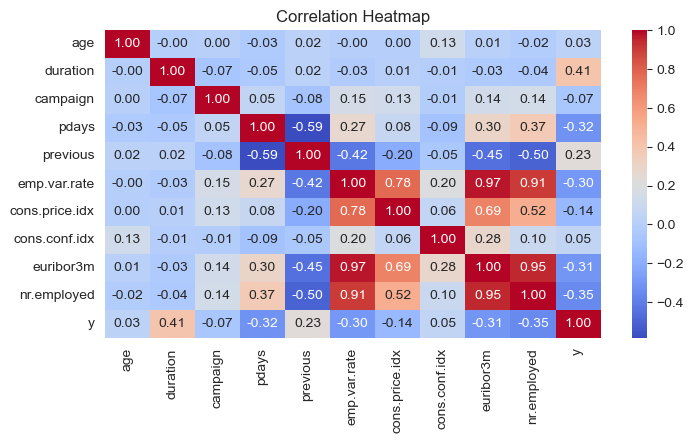

In [25]:
numerical_cols = df.select_dtypes(include=[np.number])
plt.figure(figsize=(8, 4))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

**Observations 3b** 

The most correlated features relative to target value y are: 

| Feature | Description | Correlation  | 
| :------ | :-----------| :-----------:| 
| `duration`| last contact duration in secs | 0.41|  
|`nr.employed`| number of employees | -0.35| 
|`pdays`| #days since last contact | -0.32| 
|`euribor3m`| euribor 3 month rate | -0.31| 
|`emp.var.rate`|employment variation rate | -0.30|

- suggest to ignore `duration`, which is a cheat factor (i.e. longer calls almost always mean that a deposit was subscribed)
- people subscribe more when macro economic situations were poorer (e.g. when employment rate was lower / shrinking i.e. ppl seek safety in deposits, interest rates were lower hence making the deposit cheaper) 
- people subscribe more when they were contacted more recently - older leads go cold.  
- to also note the high correlation between `nr.employed`, `euribor3m`, and `emp.var.rate` > 0.90 i.e. multicollinearity - which could affect modelling with linear models (e.g. logistic regression)

##### _Step 3c. Explore Categorical Features_

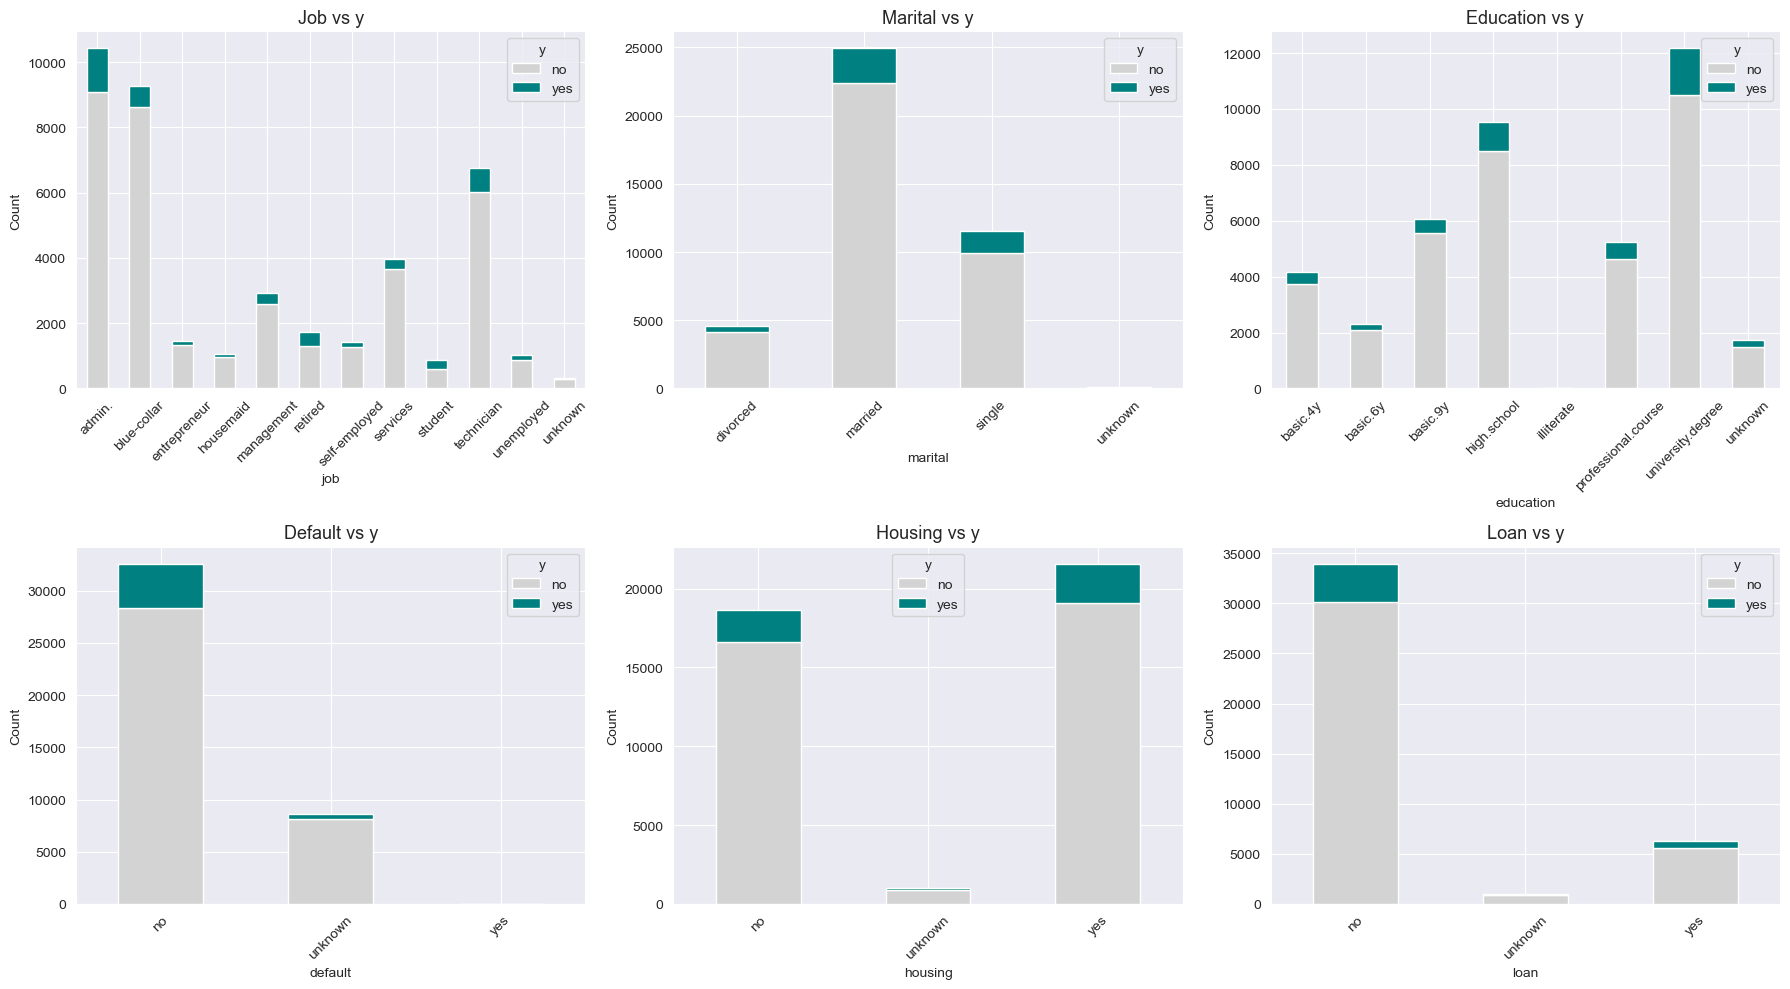

In [4]:
# List categorical columns
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# Set up 2x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop through each categorical feature
for i, col in enumerate(cat_features):
    ax = axes[i]

    # Create a crosstab of category vs outcome
    counts = pd.crosstab(df[col], df['y'])
    
    # Plot stacked bar
    counts.plot(kind='bar', stacked=True, ax=ax, color=['lightgray', 'teal'])
    
    # Titles and labels
    ax.set_title(f'{col.capitalize()} vs y', fontsize=13)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.legend(title='y', labels=['no', 'yes'])
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Observation 3c**

- Default as a feature may not be meaningful since there are almost no "yes" values (only 3)
- "Unnown" is a very small value within Housing and Loan - may want to remove these for analysis 

##### _Step 3d. Observe target feature spread_

In [11]:
counts = df['y'].value_counts()
percentages = df['y'].value_counts(normalize=True) * 100

y_table = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages.round(2)
})

print(y_table)

   Count  Percentage
y                   
0  36548       88.73
1   4640       11.27


**Observation 3d** 

- the dataset is highly imbalanced with only 11% of the values being y 

##### _Step 3e. Observe unknown features_

In [13]:
for col in ['housing', 'loan', 'marital', 'education']:
    print(df[col].value_counts(normalize=True))

housing
yes        0.523842
no         0.452122
unknown    0.024036
Name: proportion, dtype: float64
loan
no         0.824269
yes        0.151695
unknown    0.024036
Name: proportion, dtype: float64
marital
married     0.605225
single      0.280859
divorced    0.111974
unknown     0.001942
Name: proportion, dtype: float64
education
university.degree      0.295426
high.school            0.231014
basic.9y               0.146766
professional.course    0.127294
basic.4y               0.101389
basic.6y               0.055647
unknown                0.042027
illiterate             0.000437
Name: proportion, dtype: float64


In [ ]:
# check how the subscription rate for unknown compares to the overall average
for col in ['marital', 'education']:
    print(pd.crosstab(df[col], df['y'], normalize='index'))

y                0         1
marital                     
divorced  0.896791  0.103209
married   0.898427  0.101573
single    0.859959  0.140041
unknown   0.850000  0.150000
y                           0         1
education                              
basic.4y             0.897510  0.102490
basic.6y             0.917976  0.082024
basic.9y             0.921754  0.078246
high.school          0.891645  0.108355
illiterate           0.777778  0.222222
professional.course  0.886515  0.113485
university.degree    0.862755  0.137245
unknown              0.854997  0.145003


**Observation 3e**

- to consider imputing the unknown category in marital and education since its y spread is comparable to that of the average in the dataset. 

#### _Step 3f. Observe Temporal Features_ 

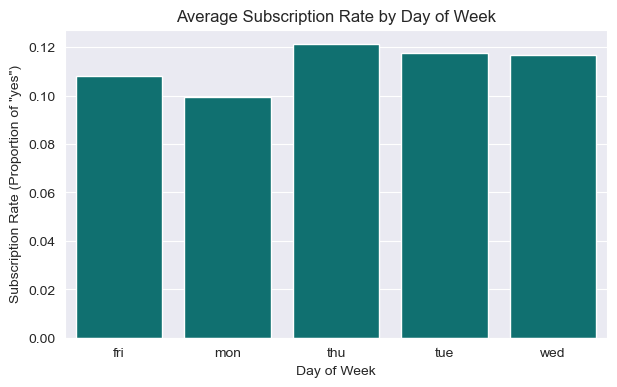

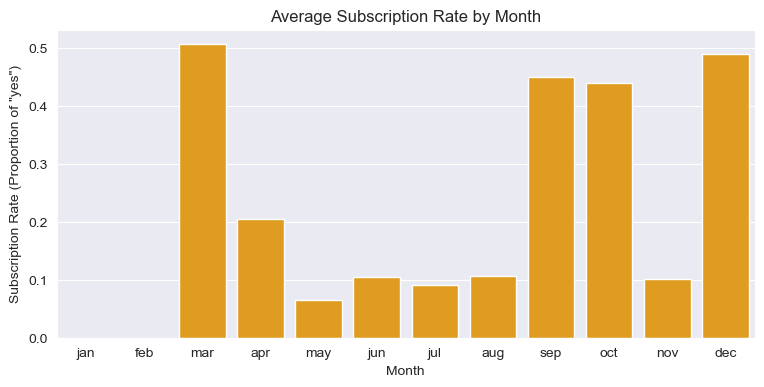

In [ ]:
# --- Subscription rate by day of week ---
day_rate = df.groupby('day_of_week')['y'].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(data=day_rate, x='day_of_week', y='y', color='teal')
plt.title('Average Subscription Rate by Day of Week')
plt.ylabel('Subscription Rate (Proportion of "yes")')
plt.xlabel('Day of Week')
plt.show()


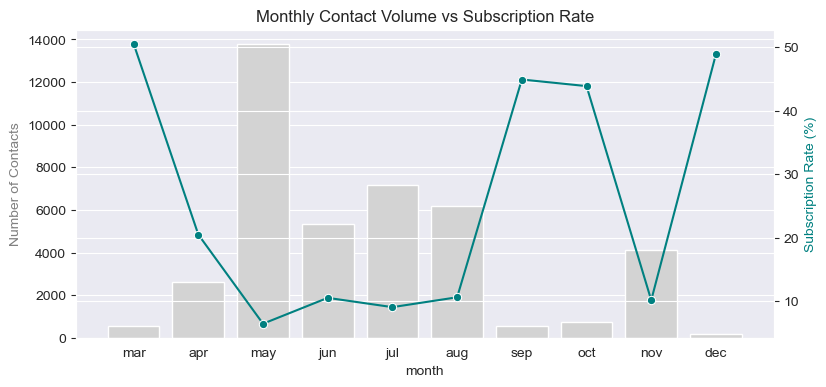

In [ ]:
# Subscription rate by month, observed against absolute contact volume 
sub_rate = df.groupby('month')['y'].mean().reindex(month_order)

fig, ax1 = plt.subplots(figsize=(9,4))

# Bar for contact volume
sns.barplot(x=contacts_per_month.index, y=contacts_per_month.values, color='lightgrey', ax=ax1)
ax1.set_ylabel('Number of Contacts', color='gray')

# Line for subscription rate
ax2 = ax1.twinx()
sns.lineplot(x=sub_rate.index, y=sub_rate.values*100, color='teal', marker='o', ax=ax2)
ax2.set_ylabel('Subscription Rate (%)', color='teal')

plt.title('Monthly Contact Volume vs Subscription Rate')
plt.show()

**Observation 3f** 

- Somehow subscription rates for March and December are better despite there not being as many calls made during that time. This could be a skew due to simple algebra (when denominator is smaller, proportion is larger for small absolute number of success rates), or there could be some correlation to it being the end of the year (people are reviewing their finances) or nearing the end of a financial year (people are planning expenditure for the next FY)
- subscription rate in summer is the weakest, likely because people are on holiday and spending. 
- No clear correlation with day of week. 

### Problem 4: Understanding the Task

**Business Objective**
The bank conducts phone campaigns to sell term deposits. Each outbound call costs time and money, and repeated calls risk customer fatigue. We want a model that predicts likelihood of subscription (y: 1/0) before the call so we can:
Prioritize high-propensity customers (improve conversion/agent productivity) and De-prioritize low-propensity segments (reduce cost/annoyance). 

**Success metrics**

Primary: AUROC (ranking quality), Average Precision (PR-AUC) (handles class imbalance)
Secondary: F1, Recall @ chosen precision (or Precision @ chosen recall, depending on operations), and Calibrated probabilities for decision-making.

## C. Preparing the Data

### Problem 5/6: Engineering Features and Split Data

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

##### _Step 5a. Engineering Features/Cleaning up the data_

In [32]:
# drop duration and default due to leakage and low variance
# drop day_of_week since no clear difference in success rate 
# drop contact method as this could be affected by the generation we are in
df = df.drop(columns=['duration', 'Default', 'day_of_week', 'contact'], errors='ignore')
df.head()

,age,job,marital,education,default,housing,loan,month,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,previous_contacted,days_since_last_contact,contacts_all_time,contact_intensity
0,56,housemaid,married,basic.4y,no,no,no,may,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
1,57,services,married,high.school,unknown,no,no,may,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
2,37,services,married,high.school,no,yes,no,may,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
3,40,admin.,married,basic.6y,no,no,no,may,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0
4,56,services,married,high.school,no,no,yes,may,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,1.0


In [22]:
# impute for marital and education as these are likely missing values 
# leave housing and loan as is as these could have meaning 
for col in ['marital', 'education']:
    mode_val = df.loc[df[col] != 'unknown', col].mode()[0]
    df[col] = df[col].replace('unknown', mode_val)

In [23]:
# fix pdays for skew (999 > -1) and create recency features
df['pdays'] = df['pdays'].replace(999, -1)
# creates new feature indicating if previously contacted (0/1)
df['previous_contacted'] = (df['pdays'] != -1).astype(int)
# creates new feature indicating days since last contact (0 if never contacted)
df['days_since_last_contact'] = df['pdays'].apply(lambda x: 0 if x == -1 else x)
# drop original pdays column
df = df.drop(columns=['pdays'])

# Create basic campaign/contact history features for better predictability
df['contacts_all_time'] = df['previous'].fillna(0) + df['campaign'].fillna(0)
# Create a proxy for call intensity, assuming even distribution of calls over days since last contact
df['contact_intensity'] = df['campaign'] / (df['days_since_last_contact'] + 1)
# drop original previous and campaign columns
df = df.drop(columns=['previous', 'campaign'])

df


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,previous_contacted,days_since_last_contact,contacts_all_time,contact_intensity
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,no,0,0,1,1.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,no,0,0,1,1.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,no,0,0,1,1.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,no,0,0,1,1.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1.1,93.994,-36.4,4.857,5191.0,no,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,yes,0,0,1,1.0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,no,0,0,1,1.0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,no,0,0,2,2.0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,-1.1,94.767,-50.8,1.028,4963.6,yes,0,0,1,1.0


In [33]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      41188 non-null  int64  
 1   job                      41188 non-null  object 
 2   marital                  41188 non-null  object 
 3   education                41188 non-null  object 
 4   default                  41188 non-null  object 
 5   housing                  41188 non-null  object 
 6   loan                     41188 non-null  object 
 7   month                    41188 non-null  object 
 8   poutcome                 41188 non-null  object 
 9   emp.var.rate             41188 non-null  float64
 10  cons.price.idx           41188 non-null  float64
 11  cons.conf.idx            41188 non-null  float64
 12  euribor3m                41188 non-null  float64
 13  nr.employed              41188 non-null  float64
 14  y                     

#### _Step 5c. Split the Dataset Before Transforming_

In [47]:
# This avoids StandardScaler data leakage by splitting before transforming
# Preserve the distribution of y in train and test sets using stratify due to class imbalance
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [51]:
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Build pipeline for pre-processing

numeric_tf = Pipeline([
    ('scale', StandardScaler()), #important for logistic regression and SVM
])

categorical_tf = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) #one hot encode categorical features
])

preprocess = ColumnTransformer([
    ('num', numeric_tf, num_cols),
    ('cat', categorical_tf, cat_cols)
])

## D. Data Modeling

#### _Problem 7: A Baseline Model_

_Step 7a: Initialise an empty results DataFrame_ 

In [52]:
# Initialize an empty results DataFrame
results_df = pd.DataFrame(columns=['Model', 'Train Time', 'Training Accuracy', 'Test Accuracy', 'ROC_AUC', 'F1_Score'])

_Step 7b: Train a Baseline Zero Rule Model_ 

This guesses based on the highest frequency class in the training data. 

In [53]:
# --- Select features and target ---
X_train_base = preprocess.fit_transform(X_train)
# Avoid training data leakage by only transforming test data
X_test_base  = preprocess.transform(X_test) 

#Instantiate the model 
model_name_base = 'Zero Rule Baseline'
dummy_clf = DummyClassifier(strategy="most_frequent")

# Train the model and record training time 
start_time_base = time.time()
dummy_clf.fit(X_train_base, y_train)
end_time_base = time.time()
training_time_base = end_time_base - start_time_base

# Predict on training data 
y_train_pred_base = dummy_clf.predict(X_train_base)
# Predict on test data
y_test_pred_base = dummy_clf.predict(X_test_base)
y_test_prob_base = dummy_clf.predict_proba(X_test_base)[:, 1]

# Compute metrics
train_acc_base = accuracy_score(y_train, y_train_pred_base)
test_acc_base = accuracy_score(y_test, y_test_pred_base)
roc_base = roc_auc_score(y_test, y_test_prob_base)
f1_base  = f1_score(y_test, y_test_pred_base)

# Append results
results_df.loc[len(results_df)] = [model_name_base, training_time_base, train_acc_base, test_acc_base, roc_base, f1_base]

# Display
results_df

,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.002167,0.887344,0.887351,0.5,0.0


**Observation 7** 

Baseline model has high accuracy due to dataset imbalance, but poor ROC/AUC and F1 scores. 

#### _Problem 8/9: A Simple Model_

Based on Observations in Step 3b, use `nr.employed` and `previous_contacted` and `days_since_last_contact` to build a baseline logsitic regression model. 

In [55]:
# --- Select features and target ---
X_train_lr3 = X_train[['nr.employed', 'previous_contacted', 'days_since_last_contact']]
X_test_lr3 = X_test[['nr.employed', 'previous_contacted', 'days_since_last_contact']]

#Instantiate the model 
model_name_lr3 = 'Logistic Regression (3 features)'
lr3 = LogisticRegression(max_iter=1000)

# Train the model and record training time 
start_time_lr3 = time.time()              
lr3.fit(X_train_lr3, y_train)
end_time_lr3 = time.time()                 
training_time_lr3 = end_time_lr3 - start_time_lr3 

# Predict on training data 
y_train_pred_lr3 = lr3.predict(X_train_lr3)
# Predict on test data
y_test_pred_lr3 = lr3.predict(X_test_lr3)
y_test_prob_lr3 = lr3.predict_proba(X_test_lr3)[:, 1]
 
# Compute metrics
train_acc_lr3 = accuracy_score(y_train, y_train_pred_lr3)
test_acc_lr3 = accuracy_score(y_test, y_test_pred_lr3)
roc_lr3 = roc_auc_score(y_test, y_test_prob_lr3)
f1_lr3  = f1_score(y_test, y_test_pred_lr3)

# Append results
results_df.loc[len(results_df)] = [model_name_lr3, training_time_lr3, train_acc_lr3, test_acc_lr3, roc_lr3, f1_lr3]

# Display
results_df


,Model,Train Time,Training Accuracy,Test Accuracy,ROC_AUC,F1_Score
0,Zero Rule Baseline,0.002167,0.887344,0.887351,0.500000,0.000000
1,Logistic Regression (3 features),32.209827,0.899090,0.899854,0.770311,0.283232


**Observation 8/9** 

- model already shows improvement from baseline 
- f1 score is very low even though accuracy is high - this could be due to imbalance of y feature 
- due to high imbalance, even if model randomly guesses 'no', it would get >80% accuracy 
- to consider using SMOTE to sample more of the y data 

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

## E. Evaluation

##### Questions